# CIFAR-10 CNN in PyTorch (translated from TensorFlow/Keras)

This notebook rewrites the original TensorFlow CNN for **CIFAR‑10** using PyTorch.
It keeps the same overall workflow: load data → define CNN → train → evaluate → predict → visualize.


In [1]:

# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

# Reproducibility & device
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('PyTorch:', torch.__version__)
print('Device :', device)


PyTorch: 2.6.0
Device : cpu


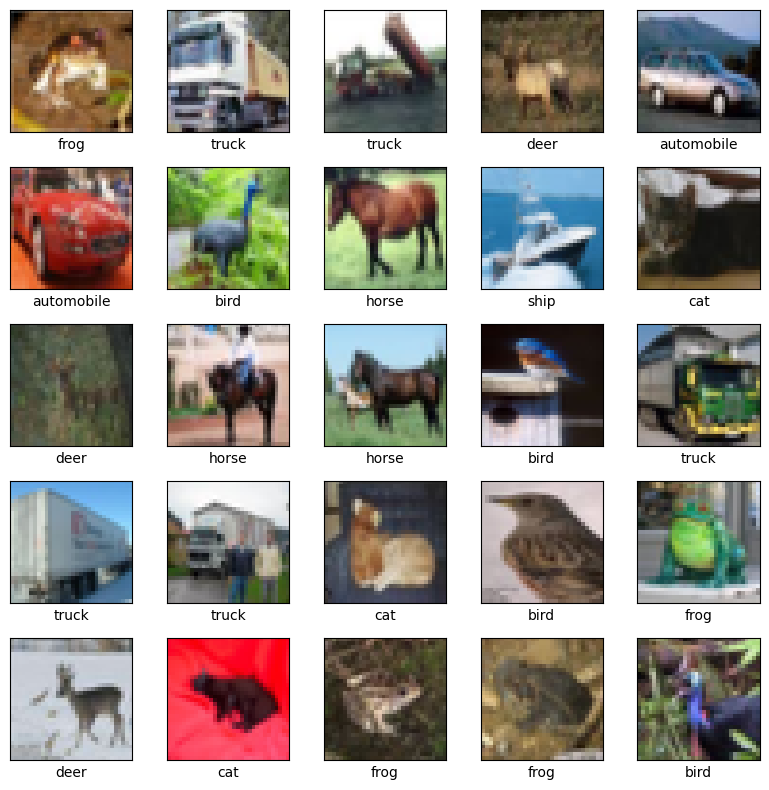

In [4]:

# Data: CIFAR-10
# Keras normalized images to [0,1]. We'll match that here.
transform = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_ds  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize a 5x5 grid as in the TF notebook
fig = plt.figure(figsize=(8,8))
for i in range(25):
    img, label = train_ds[i]
    npimg = img.permute(1,2,0).numpy()  # C,H,W -> H,W,C
    ax = plt.subplot(5,5,i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(npimg)
    ax.set_xlabel(class_names[label])
plt.tight_layout(); plt.show()


In [5]:

# Model: small CNN analogous to the Keras example
# TF model had Conv2D(32,3x3) + MaxPool(2), Conv2D(64,3x3) + MaxPool(2), Conv2D(64,3x3), Flatten, Dense(64), Dense(10)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16 -> 8x8
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 64), nn.ReLU(),
            nn.Linear(64, 10)  # logits
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)
print(model)


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [6]:

# Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

EPOCHS = 10
history = {'loss': [], 'acc': []}

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    epoch_loss = running_loss/total
    epoch_acc  = correct/total
    history['loss'].append(epoch_loss); history['acc'].append(epoch_acc)
    print(f'Epoch {epoch:2d}/{EPOCHS} - loss: {epoch_loss:.4f} - acc: {epoch_acc:.4f}')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch  1/10 - loss: 1.6254 - acc: 0.4105
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector

In [7]:

# Evaluate
model.eval()
correct, total, running_loss = 0, 0, 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        running_loss += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
test_loss = running_loss/total
test_acc = correct/total
print(f'\nTest loss: {test_loss:.4f}  Test acc: {test_acc:.4f}')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

Test loss: 0.8114  Test acc: 0.7196


In [8]:

# Predict probabilities for the test set (to mirror Keras 'predict')
softmax = nn.Softmax(dim=1)
model.eval()
all_probs = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        probs = softmax(model(xb)).cpu().numpy()
        all_probs.append(probs)
import numpy as np
predictions = np.vstack(all_probs)
print('Predictions shape:', predictions.shape)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Predictions shape: (10000, 10)


In [9]:

# Plot helpers adapted from the TF notebook
import numpy as np

def plot_image(i, predictions_array, true_label, img):
    true_label = int(true_label)
    plt.grid(False); plt.xticks([]); plt.yticks([])
    plt.imshow(img)
    predicted_label = int(np.argmax(predictions_array))
    color = 'blue' if predicted_label == true_label else 'red'
    plt.xlabel(f'{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% (true: {class_names[true_label]})',
               color=color)

def plot_value_array(predictions_array, true_label):
    true_label = int(true_label)
    plt.grid(False); plt.xticks(range(10)); plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = int(np.argmax(predictions_array))
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


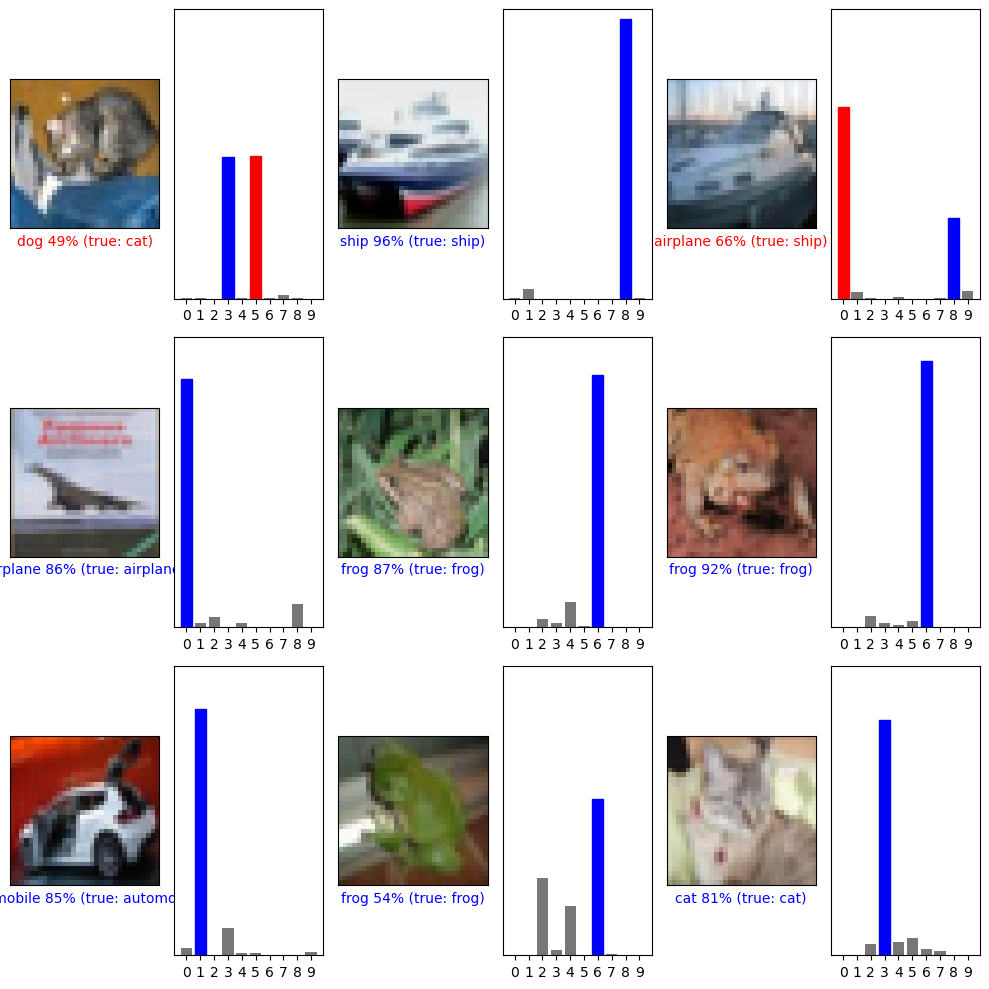

In [10]:

# Display a few predictions as in the TF notebook
fig = plt.figure(figsize=(10,10))
for i in range(9):
    img, label = test_ds[i]
    npimg = img.permute(1,2,0).numpy()
    probs = predictions[i]
    ax1 = plt.subplot(3, 2*3, 2*i+1)
    plot_image(i, probs, label, npimg)
    ax2 = plt.subplot(3, 2*3, 2*i+2)
    plot_value_array(probs, label)
plt.tight_layout(); plt.show()
